# Data Cleaning

In [ ]:
from google.colab import drive
import pandas as pd
import plotly.express as px
# 📦 Modeling Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import plotly.graph_objects as go

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 📂 Load the dataset
df = pd.read_csv("/Data_case.csv", sep=';')

# 🧹 Step 1: Convert comma decimals to floats

# Columns with comma as decimal separator
comma_decimal_cols = [
    'årspremie',           # annual premium
    'opptjentpremie',      # earned premium
    'årspremie_bil',       # car premium
    'årspremie_hus',       # house premium
    'levetid_år',          # customer lifetime
    'skadekost'            # claim cost
]

# Replace comma with dot and convert to float
for col in comma_decimal_cols:
    df[col] = df[col].str.replace(',', '.').astype(float)

# 🗓️ Step 2: Convert date columns
df["start_dato_kundeforhold"] = pd.to_datetime(df["start_dato_kundeforhold"], format="%d.%m.%Y")
df["slutt_dato_kundeforhold"] = pd.to_datetime(df["slutt_dato_kundeforhold"], format="%d.%m.%Y", errors="coerce")

# 🔁 Step 3: Encode categorical variables

# kjønn (gender): 'K' → 0 (female), 'M' → 1 (male), unknown → -1
df['kjønn'] = df['kjønn'].map({'K': 0, 'M': 1}).fillna(-1).astype(int)

# rabatt (discount): 'J' → 1 (yes), 'N' → 0 (no)
df['rabatt'] = df['rabatt'].map({'J': 1, 'N': 0}).fillna(0).astype(int)

# 🧺 Step 4: Drop column not usable for training
df.drop(columns=['avgangs_årsak'], inplace=True)

# ✅ Check final cleaned dataset
print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (51248, 21)


,alder,kjønn,rabatt,postnummer,kommunenr,start_dato_kundeforhold,slutt_dato_kundeforhold,levetid_år,hovedforfall_måned,antall_produkter,...,opptjentpremie,antall_biler,antall_hus,årspremie_bil,årspremie_hus,antall_skader,skadekost,antall_bil_skader,antall_hus_skader,avgang
0,78,0,0,6916,4602,2019-12-04,NaT,5.5,2,6,...,46661.29,1,0,411.95,11271.36,1,428491.42,1,0,0
1,78,1,1,7021,5001,2014-05-04,NaT,11.1,9,2,...,107991.03,1,0,11009.76,12396.42,0,0.00,0,0,0
2,51,-1,1,6200,1525,2014-04-30,NaT,11.1,10,4,...,92992.10,2,2,10645.72,9997.02,1,307625.52,1,0,0
3,38,0,0,1467,3205,2017-12-22,NaT,7.4,1,5,...,63322.79,2,1,5754.58,7789.57,0,0.00,0,0,0
4,75,0,0,583,301,2014-10-30,NaT,10.6,10,4,...,46499.60,2,2,1105.83,22521.82,0,0.00,0,0,0


# Decision Three

In [ ]:
########


# Condition-based features for each churn risk profile, one by one
# and calculating churn rate per group for validation

churn_conditions = {}

# 1. Short lifetime & high premium
df["short_lifetime_high_premium"] = ((df["levetid_år"] < 2) & (df["årspremie"] > 30000)).astype(int)
churn_conditions["short_lifetime_high_premium"] = df[df["short_lifetime_high_premium"] == 1]["avgang"].mean()

# 2. Few products & low premium
df["few_products_low_engagement"] = ((df["antall_produkter"] <= 1) & (df["årspremie"] <= 5000)).astype(int)
churn_conditions["few_products_low_engagement"] = df[df["few_products_low_engagement"] == 1]["avgang"].mean()

# 3. Young & short-tenure customers
df["young_and_short_tenure"] = ((df["alder"] <= 25) & (df["levetid_år"] <= 3)).astype(int)
churn_conditions["young_and_short_tenure"] = df[df["young_and_short_tenure"] == 1]["avgang"].mean()

# 4. Car-only customers
df["car_only_customer"] = ((df["antall_biler"] > 0) & (df["antall_hus"] == 0)).astype(int)
churn_conditions["car_only_customer"] = df[df["car_only_customer"] == 1]["avgang"].mean()

# 5. Many claims with high cost
df["many_claims_high_cost"] = ((df["antall_skader"] >= 3) & (df["skadekost"] > 300000)).astype(int)
churn_conditions["many_claims_high_cost"] = df[df["many_claims_high_cost"] == 1]["avgang"].mean()

# 6. Elderly with multiple claims
df["old_and_high_claims"] = ((df["alder"] > 75) & (df["antall_bil_skader"] > 2)).astype(int)
churn_conditions["old_and_high_claims"] = df[df["old_and_high_claims"] == 1]["avgang"].mean()

# 7. Short tenure + many products
df["short_tenure_many_products"] = ((df["levetid_år"] < 2) & (df["antall_produkter"] > 3)).astype(int)
churn_conditions["short_tenure_many_products"] = df[df["short_tenure_many_products"] == 1]["avgang"].mean()

# 8. Multiple houses & high cost
df["multiple_houses_high_cost"] = ((df["antall_hus"] > 1) & (df["skadekost"] > 400000)).astype(int)
churn_conditions["multiple_houses_high_cost"] = df[df["multiple_houses_high_cost"] == 1]["avgang"].mean()

# 9. Middle-aged, no discount, some claims
df["mid_age_no_discount_some_claims"] = ((df["alder"].between(35, 50)) & (df["rabatt"] == 0) & (df["antall_skader"] == 2)).astype(int)
churn_conditions["mid_age_no_discount_some_claims"] = df[df["mid_age_no_discount_some_claims"] == 1]["avgang"].mean()

# 10. Renewal month: December or January
df["renewal_winter"] = ((df["hovedforfall_måned"] >= 11) | (df["hovedforfall_måned"] == 1)).astype(int)
churn_conditions["renewal_winter"] = df[df["renewal_winter"] == 1]["avgang"].mean()

# 11. Long-term, multi-product customers (loyal)
df["long_term_multi_product"] = ((df["levetid_år"] > 10) & (df["antall_produkter"] > 2)).astype(int)
churn_conditions["long_term_multi_product"] = df[df["long_term_multi_product"] == 1]["avgang"].mean()

# 12. Discounted + average claims
df["discounted_low_claims"] = ((df["rabatt"] == 1) & (df["antall_skader"] <= 1)).astype(int)
churn_conditions["discounted_low_claims"] = df[df["discounted_low_claims"] == 1]["avgang"].mean()

import pandas as pd
import plotly.express as px

# Create a summary DataFrame
churn_summary = pd.DataFrame(list(churn_conditions.items()), columns=["Condition", "Attrition_Rate"])
churn_summary = churn_summary.sort_values("Attrition_Rate", ascending=False)

# Interactive plot with Plotly
fig = px.bar(
    churn_summary,
    x="Attrition_Rate",
    y="Condition",
    orientation="h",
    title="Churn Rate by Custom Decision-Rule Conditions",
    text="Attrition_Rate"
)
fig.update_traces(texttemplate="%{text:.2%}", textposition="outside")
fig.update_layout(xaxis_tickformat=".0%", xaxis_title="Attrition Rate", yaxis_title="Churn Rule")

fig.show()


# **Decision Tree**

# HIGH Churn Risk Profiles (Most Probable)

**1. Short lifetime & high premium**

🧾 levetid_år < 2

💰 årspremie > 30,000 NOK

❗ New customers who pay a lot are likely to feel overcharged or misled.

📊 Classification Report for Rule-Based Churn Prediction:
              precision    recall  f1-score   support

           0      0.904     0.903     0.904     46141
           1      0.135     0.136     0.135      5107

    accuracy                          0.827     51248
   macro avg      0.519     0.520     0.519     51248
weighted avg      0.828     0.827     0.827     51248



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



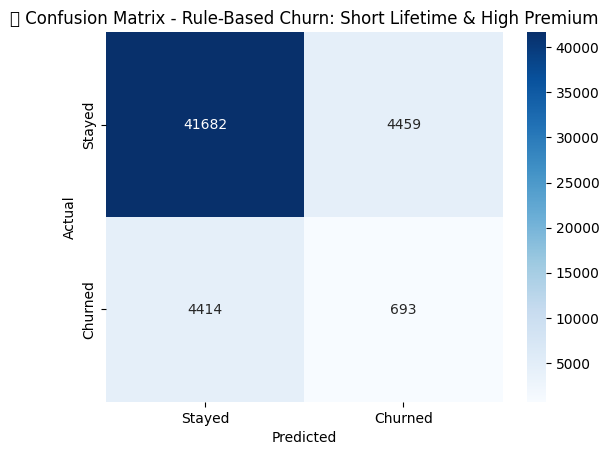

In [ ]:
# 1. Define the rule-based prediction
df["predicted_churn_rule"] = (
    (df["levetid_år"] < 2) & (df["årspremie"] > 30000)
).astype(int)

# 2. Evaluate the rule against actual churn labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = df["avgang"]
y_pred = df["predicted_churn_rule"]

# Classification report
print("📊 Classification Report for Rule-Based Churn Prediction:")
print(classification_report(y_true, y_pred, digits=3))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed", "Churned"], yticklabels=["Stayed", "Churned"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🔍 Confusion Matrix - Rule-Based Churn: Short Lifetime & High Premium")
plt.show()



# Re-create the summary_df for plotting since the environment lost its variables

# Define the rule again
df["predicted_churn_rule"] = ((df["levetid_år"] < 2) & (df["årspremie"] > 30000)).astype(int)

# Create labels for evaluation
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df_eval["predicted_churn_rule"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(
    lambda row: "Correct" if row["avgang"] == row["predicted_churn_rule"] else "Incorrect", axis=1
)

# Create the summary table again
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Return the summary to verify
summary_df




# Plotly
import plotly.express as px

fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Classification Breakdown",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)

fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)

fig.show()


**2. Few products & low premium**

📦 antall_produkter ≤ 1

💰 årspremie ≤ 5,000 NOK

❗ Low engagement, price-sensitive, easy to switch.



In [ ]:
# Rule 2: Few products & low premium
df["predicted_churn_rule_2"] = ((df["antall_produkter"] <= 1) & (df["årspremie"] <= 5000)).astype(int)

# Evaluation
from sklearn.metrics import classification_report
import pandas as pd

y_true = df["avgang"]
y_pred = df["predicted_churn_rule_2"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)

# Summary for interactive chart
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_rule_2"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_rule_2"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot with Plotly
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Few Products & Low Premium",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)

fig.show()


📊 Classification Report:
               precision  recall  f1-score  support
0                 0.900     1.0     0.947  46141.0
1                 0.118     0.0     0.001   5107.0
accuracy          0.900     0.9     0.900      0.9
macro avg         0.509     0.5     0.474  51248.0
weighted avg      0.822     0.9     0.853  51248.0


**3. Young & short-tenure customers**

👶 alder ≤ 25

⏳ levetid_år ≤ 3

❗ Early churners, maybe joined during a campaign or offer, little brand loyalty.

In [ ]:
# Rule 3: Young & short-tenure customers
df["predicted_churn_rule_3"] = ((df["alder"] <= 25) & (df["levetid_år"] <= 3)).astype(int)

# Evaluation
from sklearn.metrics import classification_report
y_true = df["avgang"]
y_pred = df["predicted_churn_rule_3"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)

# Summary for chart
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_rule_3"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_rule_3"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Young & Short-Tenure Customers",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.906   0.971     0.937  46141.000
1                 0.251   0.087     0.129   5107.000
accuracy          0.883   0.883     0.883      0.883
macro avg         0.578   0.529     0.533  51248.000
weighted avg      0.840   0.883     0.857  51248.000


**4. Car-only customers**

🚗 antall_biler > 0

🏠 antall_hus = 0

❗ Single-product customers are easier to lose. Very common in the market.

In [ ]:
# Rule 4: Car-only customers
df["predicted_churn_rule_4"] = ((df["antall_biler"] > 0) & (df["antall_hus"] == 0)).astype(int)

# Evaluation
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_rule_4"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)

# Summary DataFrame
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_rule_4"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_rule_4"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Car-Only Customers",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.904   0.750     0.820  46141.000
1                 0.111   0.281     0.159   5107.000
accuracy          0.704   0.704     0.704      0.704
macro avg         0.507   0.516     0.490  51248.000
weighted avg      0.825   0.704     0.754  51248.000


**5. Many claims with high cost**

⚠️ antall_skader ≥ 3

💸 skadekost > 300,000 NOK

❗ High-risk profile. May be dropped or charged more, increasing churn risk.

In [ ]:
# Rule 5: Many claims with high cost
df["predicted_churn_rule_5"] = ((df["antall_skader"] >= 3) & (df["skadekost"] > 300000)).astype(int)

# Evaluation
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_rule_5"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)

# Summary for interactive plot
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_rule_5"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_rule_5"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot with Plotly
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Many Claims with High Cost",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.901   0.955     0.927  46141.000
1                 0.115   0.052     0.072   5107.000
accuracy          0.865   0.865     0.865      0.865
macro avg         0.508   0.504     0.500  51248.000
weighted avg      0.823   0.865     0.842  51248.000


**6. Elderly with multiple claims**

👴 alder > 75

⚠️ antall_bil_skader > 2

❗ Possibly less tech-savvy, sensitive to premium increases, lower patience for claim processes.

In [ ]:
# 👴 Elderly with multiple claims: alder > 75 and antall_bil_skader > 2
df["elderly_multiple_claims"] = ((df["alder"] > 75) & (df["antall_bil_skader"] > 2)).astype(int)
churn_rate = df[df["elderly_multiple_claims"] == 1]["avgang"].mean()

# Create rule-based prediction column
df["predicted_churn_elderly_claims"] = df["elderly_multiple_claims"]

# Evaluate with classification report
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_elderly_claims"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate for Elderly with Multiple Car Claims: {churn_rate:.2%}")

# Summary DataFrame for plot
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_elderly_claims"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_elderly_claims"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plotly bar chart
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Elderly with Multiple Car Claims",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)

fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.900   0.995     0.945  46141.000
1                 0.090   0.005     0.009   5107.000
accuracy          0.896   0.896     0.896      0.896
macro avg         0.495   0.500     0.477  51248.000
weighted avg      0.820   0.896     0.852  51248.000
📈 Churn Rate for Elderly with Multiple Car Claims: 8.99%


**7. Customers with short tenure but many products**

⏳ levetid_år < 2

📦 antall_produkter > 3

❗ Joined recently and got bundled services — may churn all at once if one fails.

In [ ]:
# Rule 7: Short tenure but many products
df["short_tenure_many_products"] = ((df["levetid_år"] < 2) & (df["antall_produkter"] > 3)).astype(int)
churn_rate = df[df["short_tenure_many_products"] == 1]["avgang"].mean()

# Prediction column
df["predicted_churn_short_tenure_many_products"] = df["short_tenure_many_products"]

# Evaluate
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_short_tenure_many_products"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate in This Group: {churn_rate:.2%}")

# Prepare for visualization
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_short_tenure_many_products"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_short_tenure_many_products"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Short Tenure + Many Products",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)

fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.900   0.889     0.894  46141.000
1                 0.098   0.109     0.104   5107.000
accuracy          0.811   0.811     0.811      0.811
macro avg         0.499   0.499     0.499  51248.000
weighted avg      0.820   0.811     0.816  51248.000
📈 Churn Rate in This Group: 9.82%


**8. Multiple houses & high claims**

🏠 antall_hus > 1

💸 skadekost > 400,000 NOK

❗ High-value customers, but costly. Insurer may raise prices or customer may feel pushed out.

In [ ]:
# Rule 8: Multiple houses & high claims
df["multiple_houses_high_claims"] = ((df["antall_hus"] > 1) & (df["skadekost"] > 400000)).astype(int)
churn_rate = df[df["multiple_houses_high_claims"] == 1]["avgang"].mean()

# Prediction
df["predicted_churn_multiple_houses_high_claims"] = df["multiple_houses_high_claims"]

# Classification report
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_multiple_houses_high_claims"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate for Multiple Houses & High Claims: {churn_rate:.2%}")

# Summary for plotting
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_multiple_houses_high_claims"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_multiple_houses_high_claims"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Multiple Houses & High Claim Cost",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.900   0.972     0.935  46141.000
1                 0.099   0.028     0.043   5107.000
accuracy          0.878   0.878     0.878      0.878
macro avg         0.500   0.500     0.489  51248.000
weighted avg      0.821   0.878     0.846  51248.000
📈 Churn Rate for Multiple Houses & High Claims: 9.92%


**9. Middle-aged, no discount, mid-level claims**

👤 alder 35–50

📉 rabatt = 0

⚠️ antall_skader = 2

❗ Feel overlooked compared to customers who get special deals or discounts.

In [ ]:
# Rule 9: Middle-aged, no discount, mid-level claims
df["mid_age_no_discount_some_claims"] = (
    (df["alder"].between(35, 50)) & (df["rabatt"] == 0) & (df["antall_skader"] == 2)
).astype(int)

# Churn rate for this group
churn_rate = df[df["mid_age_no_discount_some_claims"] == 1]["avgang"].mean()

# Prediction column
df["predicted_churn_mid_age_discount_claims"] = df["mid_age_no_discount_some_claims"]

# Evaluate performance
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_mid_age_discount_claims"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate in This Group: {churn_rate:.2%}")

# Summary for plotting
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_mid_age_discount_claims"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_mid_age_discount_claims"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Mid-Aged, No Discount, 2 Claims",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.900   0.982     0.940  46141.000
1                 0.106   0.019     0.032   5107.000
accuracy          0.886   0.886     0.886      0.886
macro avg         0.503   0.501     0.486  51248.000
weighted avg      0.821   0.886     0.849  51248.000
📈 Churn Rate in This Group: 10.64%


**10. Due for renewal in Dec–Jan**

📆 hovedforfall_måned ≥ 11

❗ End-of-year renewals often trigger price increases or shopping around for alternatives.

In [ ]:
# Rule 10: Due for renewal in Dec–Jan
df["renewal_winter"] = (df["hovedforfall_måned"] >= 11).astype(int)
churn_rate = df[df["renewal_winter"] == 1]["avgang"].mean()

# Prediction column
df["predicted_churn_renewal_winter"] = df["renewal_winter"]

# Classification report
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_renewal_winter"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate in This Group: {churn_rate:.2%}")

# Summary for plotting
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_renewal_winter"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_renewal_winter"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Interactive plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Renewal in December or January",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()



📊 Classification Report:
               precision  recall  f1-score    support
0                 0.900   0.834     0.866  46141.000
1                 0.099   0.164     0.123   5107.000
accuracy          0.768   0.768     0.768      0.768
macro avg         0.500   0.499     0.495  51248.000
weighted avg      0.820   0.768     0.792  51248.000
📈 Churn Rate in This Group: 9.88%


## Low Churn Risk Profiles (Loyal)

**11. Long-term, multi-product customers**

⏳ levetid_år > 10

📦 antall_produkter > 2

❗ Strong loyalty. High retention. Worth nurturing.

In [ ]:
# Rule 11: Long-term, multi-product customers
df["long_term_multi_product"] = ((df["levetid_år"] > 10) & (df["antall_produkter"] > 2)).astype(int)
churn_rate = df[df["long_term_multi_product"] == 1]["avgang"].mean()

# Prediction column
df["predicted_churn_long_term_multi_product"] = df["long_term_multi_product"]

# Classification report
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_long_term_multi_product"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate in This Group: {churn_rate:.2%}")

# Summary for plotting
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_long_term_multi_product"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_long_term_multi_product"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Long-Term, Multi-Product Customers",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.887   0.843     0.865  46141.000
1                 0.023   0.033     0.027   5107.000
accuracy          0.762   0.762     0.762      0.762
macro avg         0.455   0.438     0.446  51248.000
weighted avg      0.801   0.762     0.781  51248.000
📈 Churn Rate in This Group: 2.26%


**12. Discounted customers with average claims**

💳 rabatt = 1

⚠️ antall_skader ≤ 1

❗ Discounts help retain price-sensitive customers.

In [ ]:
# Rule 12: Discounted customers with average claims
df["discounted_avg_claims"] = ((df["rabatt"] == 1) & (df["antall_skader"] <= 1)).astype(int)
churn_rate = df[df["discounted_avg_claims"] == 1]["avgang"].mean()

# Predict: stay if meets rule, else churn
df["predicted_churn_discounted_avg"] = (df["discounted_avg_claims"] == 0).astype(int)

# Classification report
from sklearn.metrics import classification_report
import pandas as pd
y_true = df["avgang"]
y_pred = df["predicted_churn_discounted_avg"]
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
print("📊 Classification Report:\n", report_df)
print(f"📈 Churn Rate in Discounted Customers with Average Claims: {churn_rate:.2%}")

# Summary for plotting
df_eval = df.copy()
df_eval["True_Label"] = df_eval["avgang"].map({0: "Stayed", 1: "Churned"})
df_eval["Prediction"] = df["predicted_churn_discounted_avg"].map({0: "Stayed", 1: "Churned"})
df_eval["Result"] = df_eval.apply(lambda r: "Correct" if r["avgang"] == r["predicted_churn_discounted_avg"] else "Incorrect", axis=1)
summary_df = df_eval.groupby(["True_Label", "Prediction", "Result"]).size().reset_index(name="Count")
summary_df["Percentage"] = (summary_df["Count"] / summary_df["Count"].sum() * 100).round(2)

# Plot
import plotly.express as px
fig = px.bar(
    summary_df,
    x="True_Label",
    y="Count",
    color="Result",
    barmode="group",
    facet_col="Prediction",
    text="Percentage",
    color_discrete_map={"Correct": "green", "Incorrect": "red"},
    title="📊 Rule-Based Churn Prediction: Discounted Customers with Average Claims",
    labels={"Count": "Number of Customers", "True_Label": "Actual Status"}
)
fig.update_traces(
    hovertemplate="<b>True Label:</b> %{x}<br>" +
                  "<b>Prediction:</b> %{facet_col}<br>" +
                  "<b>Result:</b> %{legendgroup}<br>" +
                  "<b>Count:</b> %{y}<br>" +
                  "<b>Percentage:</b> %{text}%<extra></extra>"
)
fig.update_layout(
    yaxis_title="Number of Customers",
    xaxis_title="Actual Churn Status",
    legend_title="Prediction Accuracy",
    height=500
)
fig.show()


📊 Classification Report:
               precision  recall  f1-score    support
0                 0.928   0.163     0.278  46141.000
1                 0.105   0.886     0.188   5107.000
accuracy          0.235   0.235     0.235      0.235
macro avg         0.517   0.525     0.233  51248.000
weighted avg      0.846   0.235     0.269  51248.000
📈 Churn Rate in Discounted Customers with Average Claims: 7.19%


# Build and Evaluate a Churn Prediction Model: **Random Forest**

In [ ]:
# 🎯 Step 1: Define Features and Target
target = 'avgang'  # churn (1 = left the company)
features = [
    'alder',                # age (alder)
    'kjønn',                # gender (kjønn)
    'rabatt',               # discount (rabatt)
    'postnummer',           # postal code (postnummer)
    'kommunenr',            # municipality (kommunenr)
    'levetid_år',           # customer lifetime (levetid_år)
    'hovedforfall_måned',   # main due month (hovedforfall_måned)
    'antall_produkter',     # number of products (antall_produkter)
    'årspremie',            # annual premium (årspremie)
    'opptjentpremie',       # earned premium (opptjentpremie)
    'antall_biler',         # number of cars (antall_biler)
    'antall_hus',           # number of houses (antall_hus)
    'årspremie_bil',        # car premium (årspremie_bil)
    'årspremie_hus',        # house premium (årspremie_hus)
    'antall_skader',        # number of claims (antall_skader)
    'skadekost',            # claim cost (skadekost)
    'antall_bil_skader',    # number of car claims (antall_bil_skader)
    'antall_hus_skader'     # number of house claims (antall_hus_skader)
]

X = df[features]
y = df[target]

# 🧪 Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Step 3: Train Model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42) #build 100 decision trees in the forest.
model.fit(X_train, y_train)

# 📈 Step 4: Evaluate Model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# 🧠 Step 5: Feature Importance (Interactive Plot)
importances = model.feature_importances_
feature_data = pd.DataFrame({
    "Feature (Norsk)": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)

fig = go.Figure(
    data=[
        go.Bar(
            x=feature_data["Importance"],
            y=feature_data["Feature (Norsk)"],
            orientation="h",
            marker=dict(color=feature_data["Importance"], colorscale="Blues"),
            hoverinfo="x+y"
        )
    ]
)
fig.update_layout(
    title="Feature Importance (Random Forest)",
    xaxis_title="Importance",
    yaxis_title="Feature (Norsk)",
    height=600
)
fig.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      9294
           1       0.40      0.01      0.02       956

    accuracy                           0.91     10250
   macro avg       0.65      0.50      0.48     10250
weighted avg       0.86      0.91      0.86     10250

ROC AUC Score: 0.7133203542484331


**Why I Chose Random Forest**

For this churn prediction task, I chose a** Random Forest model **because it provides a strong balance between accuracy, robustness, and interpretability. A Random Forest is an ensemble of decision trees that each make their own prediction based on a random subset of data and features. The final prediction is made through a **majority vote**. This approach reduces overfitting and captures complex, non-linear relationships in the data. Additionally, Random Forest offers feature importance insights, which are critical for understanding which factors most influence customer churn — a key consideration in financial services and retention strategies.

**Explanation of Random Forest and Decision Tree models:**

The model has high F1 for the 'Stayed' class but underperforms on 'Churn'. This is likely due to class imbalance. To address this, I would adjust the classification threshold, use class weights, or apply SMOTE to better capture minority churn cases. In real-world deployments, predicting churn — even with false positives — can be more valuable than missing it entirely.

In [ ]:
#Count of churned and non-churned users:
df['avgang'].value_counts()

,count
avgang,
0,46141
1,5107


In [ ]:
# Ensure correct data types by replacing commas and converting to numeric
columns_to_fix = [
    'rabatt', 'levetid_år', 'årspremie', 'opptjentpremie',
    'årspremie_bil', 'årspremie_hus', 'skadekost'
]

for col in columns_to_fix:
    df[col] = df[col].astype(str).str.replace(",", ".").str.replace(" ", "").str.strip()
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with any NaN values in feature columns
df.dropna(subset=features + ['avgang'], inplace=True)

# Redefine X and y
X = df[features]
y = df['avgang']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest with class_weight
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict on full dataset
y_full_pred = model.predict(X)

# Final full classification report
from sklearn.metrics import classification_report
full_report = classification_report(y, y_full_pred, digits=3, output_dict=True)
full_report_df = pd.DataFrame(full_report).transpose()

full_report_df


fig.show()

In [ ]:


#Feature Importance (Interactive Plot)
importances = model.feature_importances_
feature_data = pd.DataFrame({
    "Feature (Norsk)": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)

fig = go.Figure(
    data=[
        go.Bar(
            x=feature_data["Importance"],
            y=feature_data["Feature (Norsk)"],
            orientation="h",
            marker=dict(color=feature_data["Importance"], colorscale="Blues"),
            hoverinfo="x+y"
        )
    ]
)
fig.update_layout(
    title="Feature Importance (Random Forest)",
    xaxis_title="Importance",
    yaxis_title="Feature (Norsk)",
    height=600
)

In [ ]:
print(feature_data.sort_values(by="Importance", ascending=False)["Feature (Norsk)"].tolist())



['levetid_år', 'alder', 'antall_produkter', 'årspremie_bil', 'opptjentpremie', 'årspremie_hus', 'årspremie', 'postnummer', 'kommunenr', 'hovedforfall_måned', 'skadekost', 'antall_biler', 'antall_hus', 'antall_skader', 'rabatt', 'kjønn', 'antall_bil_skader', 'antall_hus_skader']


# **Visualization**

In [ ]:
#levetid_år

import plotly.express as px

fig = px.histogram(
    df,
    x="levetid_år",
    color="avgang",
    nbins=40,
    barmode="group",  # Side-by-side bars
    color_discrete_map={0: "green", 1: "red"},
    labels={"avgang": "Churn Status", "levetid_år": "Customer Lifetime (Years)"},
    title="⏳ Churn Distribution by Customer Lifetime (levetid_år)"
)
fig.update_layout(
    xaxis_title="Customer Lifetime (Years)",
    yaxis_title="Number of Customers",
    legend_title="Churn",
    height=500
)
fig.show()


fig = px.box(
    df,
    x="avgang",
    y="levetid_år",
    color="avgang",
    color_discrete_map={0: "green", 1: "red"},
    labels={"avgang": "Churn Status", "levetid_år": "Customer Lifetime (Years)"},
    title="📦 Boxplot: Customer Lifetime (levetid_år) vs Churn"
)
fig.update_layout(
    xaxis=dict(tickvals=[0, 1], ticktext=["Stayed", "Churned"]),
    yaxis_title="Customer Lifetime (Years)",
    height=500
)
fig.show()


**levetid_år:** The boxplot confirms this, with churned customers having significantly lower median and overall lifetimes compared to those who stayed. This suggests that early-stage retention is a critical opportunity for reducing churn.

In [ ]:
#opptjentpremie:

import plotly.express as px

# Side-by-side histogram
fig_hist = px.histogram(
    df,
    x="opptjentpremie",
    color="avgang",
    nbins=40,
    barmode="group",
    color_discrete_map={0: "green", 1: "red"},
    labels={"avgang": "Churn Status", "opptjentpremie": "Earned Premium (NOK)"},
    title="💰 Churn Distribution by Earned Premium (opptjentpremie)"
)
fig_hist.update_layout(
    xaxis_title="Earned Premium (NOK)",
    yaxis_title="Number of Customers",
    legend_title="Churn",
    height=500
)
fig_hist.show()

# Boxplot
fig_box = px.box(
    df,
    x="avgang",
    y="opptjentpremie",
    color="avgang",
    color_discrete_map={0: "green", 1: "red"},
    labels={"avgang": "Churn Status", "opptjentpremie": "Earned Premium (NOK)"},
    title="📦 Boxplot: Earned Premium (opptjentpremie) vs Churn"
)
fig_box.update_layout(
    xaxis=dict(tickvals=[0, 1], ticktext=["Stayed", "Churned"]),
    yaxis_title="Earned Premium (NOK)",
    height=500
)
fig_box.show()



**opptjentpremie:** In the bar chart, we see that customers who churn tend to have lower earned premiums — meaning they haven’t paid much into the company yet. This could reflect early-stage customers or low-engagement users.

In [ ]:
#Alder:

import plotly.express as px

# 📊 Side-by-side histogram (age distribution by churn)
fig_hist = px.histogram(
    df,
    x="alder",
    color="avgang",
    nbins=40,
    barmode="group",
    color_discrete_map={0: "green", 1: "red"},
    labels={"avgang": "Churn Status", "alder": "Age"},
    title="👤 Churn Distribution by Age (alder)"
)
fig_hist.update_layout(
    xaxis_title="Age",
    yaxis_title="Number of Customers",
    legend_title="Churn",
    height=500
)
fig_hist.show()

# 📦 Boxplot
fig_box = px.box(
    df,
    x="avgang",
    y="alder",
    color="avgang",
    color_discrete_map={0: "green", 1: "red"},
    labels={"avgang": "Churn Status", "alder": "Age"},
    title="📦 Boxplot: Age (alder) vs Churn"
)
fig_box.update_layout(
    xaxis=dict(tickvals=[0, 1], ticktext=["Stayed", "Churned"]),
    yaxis_title="Age",
    height=500
)
fig_box.show()


**Alder:** These plots show that churn tends to be slightly higher among younger customers. The histogram indicates more churn in the lower age ranges, while the boxplot confirms that churned customers have a slightly lower median age. This could reflect lower loyalty or higher price sensitivity among younger segments.